In [1]:
from __future__ import annotations

import datetime
import logging

import catboost
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import shap
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from xgboost import XGBRegressor

logging.basicConfig(format="%(asctime)s %(levelname)s %(message)s", level="INFO")
log = logging.getLogger("notebook")

In [2]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")
test_id_list = list(test_df["id"])

train_df = train_df.drop(columns=["id"])
test_df = test_df.drop(columns=["id"])

In [3]:
def feature_engineering(df):
    df = df.copy()
    df["age_group"] = df["person_age"].clip(lower=0, upper=99).map(lambda x: x // 10 * 10)
    df["loan_to_income"] = df["loan_amnt"] / df["person_income"]
    df["monthly_income"] = df["person_income"] / 12
    df["monthly_debt"] = df["loan_amnt"] * (1 + df["loan_int_rate"]) / 12
    df["dti_ratio"] = df["monthly_debt"] / df["monthly_income"]
    return df


train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)

In [4]:
cat_features = [
    "person_home_ownership",
    "loan_intent",
    "loan_grade",
    "cb_person_default_on_file",
    "age_group",
]
num_features = [
    "dti_ratio",
    "monthly_debt",
    "monthly_income",
    "person_age",
    "person_income",
    "person_emp_length",
    "loan_amnt",
    "loan_int_rate",
    "loan_percent_income",
    "cb_person_cred_hist_length",
    "loan_to_income",
]

features = sorted(cat_features + num_features)

## Hyper parameter tunning with Optuna

In [5]:
# def objective(trial):
#     cv = StratifiedKFold(5, shuffle=True, random_state=9999)
#     param = {
#         "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
#         "depth": trial.suggest_int("depth", 1, 12),
#         "eval_metric": "AUC",
#         "cat_features": cat_features,
#         "random_state": 9999,
#         "iterations": 1000,
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
#         "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-1, 1.0, log=True),
#     }
#     score_list = []
#     for train_idx, val_idx in cv.split(train_df, y=train_df["loan_status"]):
#         train_x = train_df.iloc[train_idx][features]
#         train_y = train_df.iloc[train_idx]["loan_status"]
#         valid_x = train_df.iloc[val_idx][features]
#         valid_y = train_df.iloc[val_idx]["loan_status"]
#         cb_clf = catboost.CatBoostClassifier(**param)
#         cb_clf.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=200)
#         valid_y_pred = cb_clf.predict_proba(valid_x)[:, 1]
#         score = roc_auc_score(valid_y, valid_y_pred)
#         score_list.append(score)
#     return np.mean(score_list)


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=200)
# cb_clf_params = study.best_params

# Best is trial 36 with value: 0.9553711593693648.
# cb_clf_params = {
#     "objective": "Logloss",
#     "colsample_bylevel": 0.0993013825516781,
#     "depth": 5,
#     "learning_rate": 0.29432288832602616,
#     "l2_leaf_reg": 0.8531657930570534,
# }

## Create Submission

### Vanilla version

In [6]:
# params = {
#     "objective": "Logloss",
#     "colsample_bylevel": 0.0993013825516781,
#     "depth": 5,
#     "learning_rate": 0.29432288832602616,
#     "l2_leaf_reg": 0.8531657930570534,
#     "eval_metric": "AUC",
#     "random_state": 9999,
#     "iterations": 1000,
#     "cat_features": cat_features,
# }
# cb_clf = catboost.CatBoostClassifier(**params)
# cb_clf.fit(train_df[features], train_df["loan_status"])
# test_y_pred = cb_clf.predict_proba(test_df[features])[:, 1]
# pd.DataFrame({"id": test_id_list, "loan_status": test_y_pred}).to_csv(
#     "./data/catboost_vanilla.csv", index=False
# )

### Catboost + CV mean

In [7]:
cv_pred_dict = {}
cv = StratifiedKFold(5, shuffle=True, random_state=9999)
params = {
    "objective": "Logloss",
    "colsample_bylevel": 0.0993013825516781,
    "depth": 5,
    "learning_rate": 0.29432288832602616,
    "l2_leaf_reg": 0.8531657930570534,
    "eval_metric": "AUC",
    "random_state": 9999,
    "iterations": 1000,
    "cat_features": cat_features,
}
for cv_idx, (train_idx, val_idx) in zip(range(5), cv.split(train_df, y=train_df["loan_status"])):
    train_x = train_df.iloc[train_idx][features]
    train_y = train_df.iloc[train_idx]["loan_status"]
    valid_x = train_df.iloc[val_idx][features]
    valid_y = train_df.iloc[val_idx]["loan_status"]
    cb_clf = catboost.CatBoostClassifier(**params)
    cb_clf.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=200)

    valid_y_pred = cb_clf.predict_proba(valid_x[features])[:, 1]
    cv_score = roc_auc_score(valid_y, valid_y_pred)
    log.info("cv_score: %s", cv_score)

    test_y_pred = cb_clf.predict_proba(test_df[features])[:, 1]
    cv_key = f"cv{cv_idx}"
    if cv_key not in cv_pred_dict:
        cv_pred_dict[cv_key] = test_y_pred
cv_pred_df = pd.DataFrame(cv_pred_dict)
test_y_pred = cv_pred_df.mean(axis=1)
pd.DataFrame({"id": test_id_list, "loan_status": test_y_pred}).to_csv(
    "./data/catboost_cv_mean.csv", index=False
)

2024-10-12 03:38:42,761 INFO cv_score: 0.9496737512151361
2024-10-12 03:38:57,292 INFO cv_score: 0.9565567344285482
2024-10-12 03:39:12,205 INFO cv_score: 0.9505525781124897
2024-10-12 03:39:26,096 INFO cv_score: 0.9556868964129599
2024-10-12 03:39:41,395 INFO cv_score: 0.9489088628588335


In [13]:
explainer = shap.TreeExplainer(cb_clf)
shap_values = explainer.shap_values(X=train_df[features], y=train_df["loan_status"])

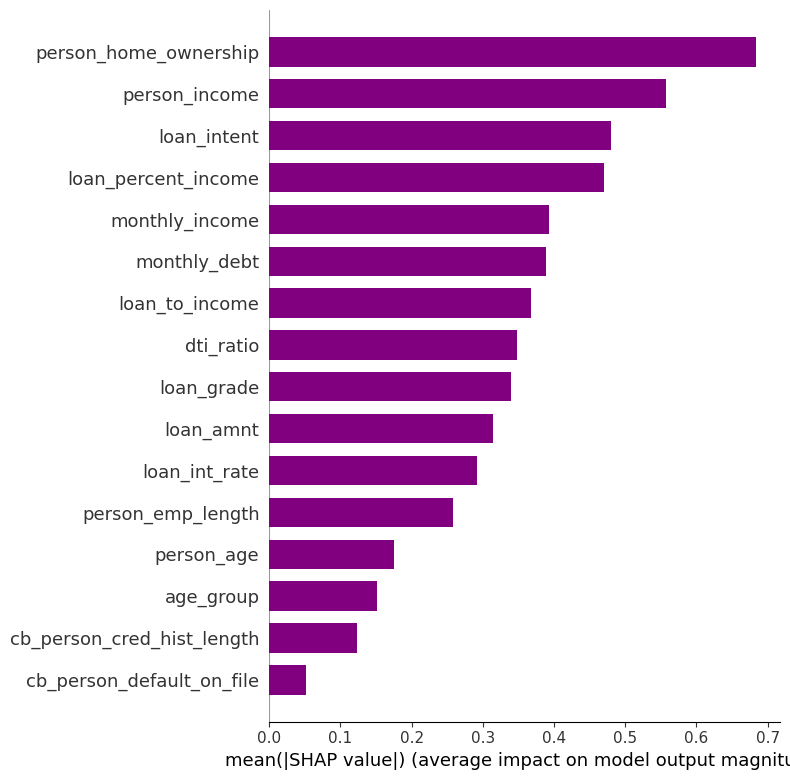

In [14]:
shap.summary_plot(
    shap_values,
    train_df[features],
    plot_type="bar",
    class_names=sorted(set(train_df["loan_status"])),
    color="purple",
    show=False,
)

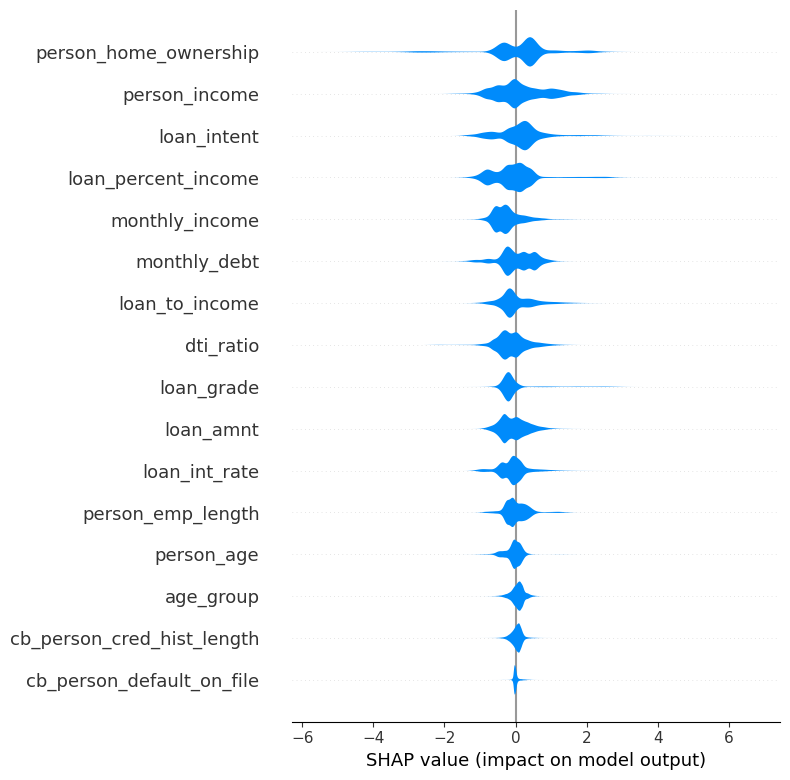

In [15]:
shap.summary_plot(shap_values, features, plot_type="violin", show=False)